In [1]:
import numpy as np
import pandas as pd
from dna_features_viewer import GraphicFeature, GraphicRecord
from Bio import GenBank
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import re
from matplotlib import pyplot as plt
from functions import volcano, annot_topn

In [3]:
core={'ctg1_935':1,'ctg1_944':1,'ctg1_946':1,'ctg1_947':1,'ctg1_950':1,'ctg1_955':1,
     'ctg1_956':1,'ctg1_957':1,'ctg1_958':1,'ctg1_960':1,'ctg1_962':1,
     'ctg1_981':1,'ctg1_982':1}
additional = {'ctg1_934':1,'ctg1_938':1,'ctg1_940':1,'ctg1_941':1,'ctg1_952':1,
              'ctg1_953':1,'ctg1_983':1}
regu = {'ctg1_990':-1}
gene_ids = [x.replace('ctg','') for x in ( list(core.keys())+list(additional.keys()) ) ]

In [3]:
# hmx2_proteins = SeqIO.parse( "../data/Genome_HMX2/protein_hmx2.fa", "fasta")
# eps_genes = []
# for seq_record in hmx2_proteins:
#     if str(seq_record.id) in gene_ids:
#         eps_genes.append( SeqRecord(Seq( str(seq_record.seq).replace('*','') ),\
#                                     id = str(seq_record.id), name="",description="") )
# print(len(eps_genes))
# SeqIO.write( eps_genes, '../data/Genome_HMX2/EPS_BGC_proteins.fasta' ,"fasta")

In [4]:
genome_annot = pd.read_csv('../data/Genome_HMX2/hmx2_annotation.csv')
Gene_IDs = list(genome_annot['Gene_ID'])
genome_annot['Gene_ID'] = [x.strip() for x in Gene_IDs ]

In [5]:
bgc_annot = (genome_annot[genome_annot.Gene_ID.isin(gene_ids)]).reset_index().drop(['index'],axis=1)

In [6]:
DE = {'ctg1_935':'wecB', 'ctg1_944':'waaB, rfaB','ctg1_946':'GT','ctg1_947':'Wzx','ctg1_950':'rfbB,rffG',
      'ctg1_955':'galE','ctg1_956':'GT','ctg1_957':'GT','ctg1_958':'GT','ctg1_960':'GT','ctg1_962':'GT',
     'ctg1_981':'GT','ctg1_982':'GT','ctg1_934':'Beta-lactamase','ctg1_938':'glf',
      'ctg1_940':'cps2B, cps4B','ctg1_941':'Beta-lactamase','ctg1_952':'cps2A, cps4A',
              'ctg1_953':'cps2B, cps4B','ctg1_983':'glf'}

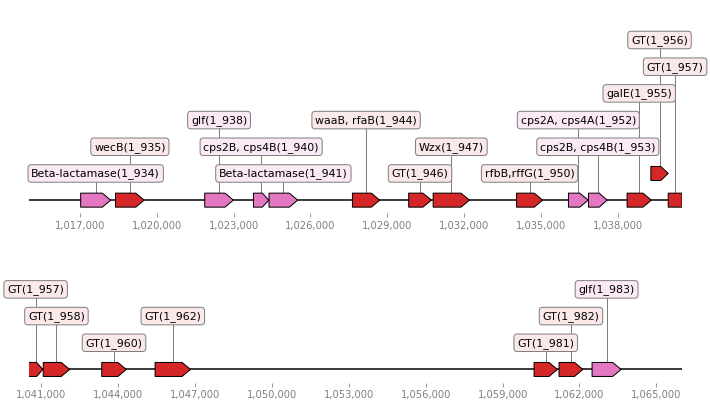

In [13]:
features = []
for i in range(len(bgc_annot.index)):
    gene_id = bgc_annot['Gene_ID'][i]
    left, right = bgc_annot['Start'][i], bgc_annot['End'][i]
    if bgc_annot['Strand'][i] == '+':
        strand = 1
    else:
        strand = -1
    ctg_id = 'ctg'+gene_id
    label = DE[ctg_id]+'('+gene_id+')'
    if ctg_id in core.keys():
        color = 'tab:red'
    elif ctg_id in additional.keys():
        color = 'tab:pink'
    else:
        color = 'tab:blue'
    
    features.append(GraphicFeature(start= left, end= right, strand=strand, color=color,label=label) )
record = GraphicRecord( first_index=1015000, sequence_length=51000, features=features)
record.plot_on_multiple_lines(nucl_per_line=26000, n_lines=2);
# plt.savefig('../../../../EPS_LP/Figures/EPS_BGC.svg',format='svg',dpi=150)

# Blast to Uniprot sequences

In [2]:
column_names = ('query acc.ver, subject acc.ver, % identity, alignment length, mismatches, gap opens, q. start, q. end, s. start, s. end, evalue, bit score').split(', ')
data = []
ffile = open('../data/Genome_HMX2/eps_blast_uniprot.tsv', "rt")
lines = ffile.readlines()
ffile.close()
for line in lines:
    line = line.strip()
    if '#' not in line:
        data.append( line.split('\t'))   

In [3]:
proAB = pd.read_csv('../data/Proteomics/Proteomics_AB.csv')
proB = pd.read_excel('../data/Proteomics/Proteomics_B.xlsx')
name_dict = {proB['Accession'][i]: proB['Gene Name'][i] for i in proB.index}

In [4]:
blast_result = pd.DataFrame(data ,columns=column_names)
uniprot_genes = list(blast_result['subject acc.ver'])

deg_5d5vs6d5_B = pd.read_csv("../data/Proteomics/deg_5d5vs6d5_B.csv")
deg_5vs6d5_B = pd.read_csv("../data/Proteomics/deg_5vs6d5_B.csv")
deg_4d5vs6d5_B = pd.read_csv("../data/Proteomics/deg_4d5vs6d5_B.csv")

eps_5d5 = deg_5d5vs6d5_B[deg_5d5vs6d5_B.ID.isin( uniprot_genes  )].reset_index().drop(['index'],axis=1)
eps_5 = deg_5vs6d5_B[deg_5vs6d5_B.ID.isin( uniprot_genes  )].reset_index().drop(['index'],axis=1)
eps_4d5 = deg_4d5vs6d5_B[deg_4d5vs6d5_B.ID.isin( uniprot_genes  )].reset_index().drop(['index'],axis=1)

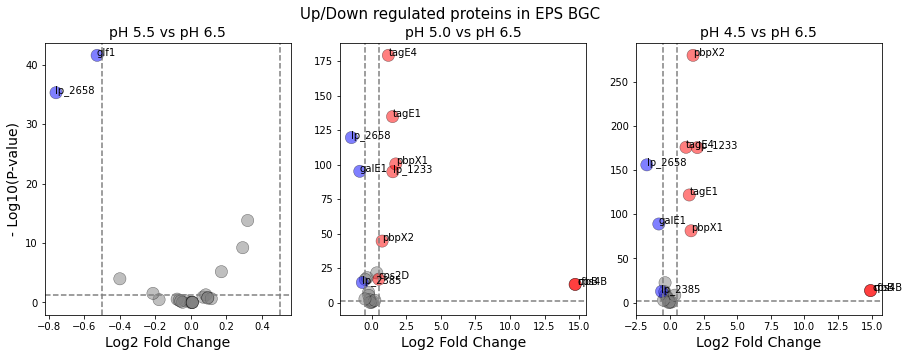

In [6]:
pv_cut = 0.05
fig, axs = plt.subplots(1,3,figsize=(15,5))
volcano( eps_5d5, 'log2FoldChange', 'padj', 0.5, pv_cut, 150,axs[0])
annot_topn(eps_5d5, 10, name_dict, 'log2FoldChange', 'padj', 0.5, pv_cut, 10, axs[0] )
volcano( eps_5, 'log2FoldChange', 'padj', 0.5, pv_cut,150, axs[1])
annot_topn( eps_5, 10, name_dict, 'log2FoldChange', 'padj', 0.5, pv_cut, 10, axs[1] )
volcano( eps_4d5, 'log2FoldChange', 'padj', 0.5, pv_cut,150, axs[2])
annot_topn(  eps_4d5, 10, name_dict, 'log2FoldChange', 'padj', 0.5, pv_cut, 10, axs[2] )
for ax in axs:
    ax.set_xlabel('Log2 Fold Change', fontsize=14)
axs[0].set_ylabel('- Log10(P-value)', fontsize=14)
axs[0].set_title('pH 5.5 vs pH 6.5', fontsize=14)
axs[1].set_title('pH 5.0 vs pH 6.5', fontsize=14)
axs[2].set_title('pH 4.5 vs pH 6.5', fontsize=14)
plt.suptitle('Up/Down regulated proteins in EPS BGC',fontsize=15)
# plt.savefig('../../../../EPS_LP/Figures/deg_epsbgc.svg',format='svg',dpi=150)

# EPS composition

In [3]:
mw = {'Man':180.156,'GlcN':179.17 ,'Glc':180.156,'Gal':180.156,'GalA': 194.139, 'Ara': 150.13}
sugars = {'Man':176.719,'GlcN':22.150 ,'Glc':161.737,'Gal':33.919,'GalA': 0.697, 'Ara': 0.153 }
sugars_mol = {g: sugars[g]/mw[g] for g in mw.keys()}
total = sum( sugars_mol.values() )
sugars_molfrac = {g: sugars_mol[g]/total for g in sugars_mol.keys()}

links = {'t-Manp':36.055,'1,2,6-Manp':15.474,'1,2-Manp':14.888, 't-Glcp':13.867,
        '1,4-Glcp':4.404, '1,6-Glcp':3.759,'1,3-Glcp':3.676,'t-Galp':1.150, '1,4-Galp':4.622,}
links['Others'] = 100-sum( links.values() )

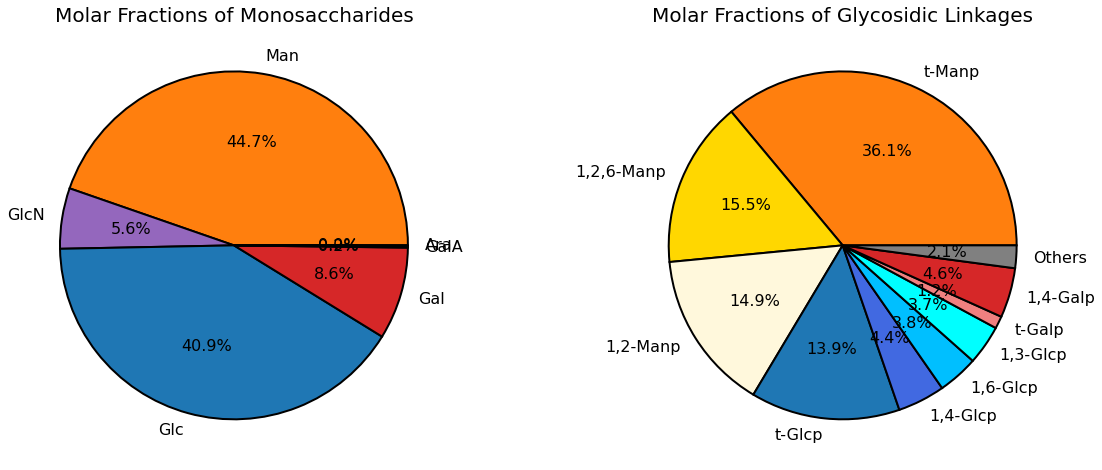

In [4]:
color_sugars = ['tab:orange','tab:purple','tab:blue','tab:red','gray','gray']
color_links = ['tab:orange','gold','cornsilk','tab:blue','royalblue','deepskyblue','cyan',
               'lightcoral','tab:red','gray']
fig, axs = plt.subplots(1,2, figsize=(20,8))
axs[0].pie(sugars_molfrac.values(), labels=sugars_molfrac.keys(), autopct='%1.1f%%',
       wedgeprops = {"edgecolor" : "black",'linewidth': 2,'antialiased': True},
      textprops={'fontsize':16}, colors = color_sugars);
axs[0].set_title('Molar Fractions of Monosaccharides', fontsize=20)
axs[1].pie(links.values(), labels=links.keys(), autopct='%1.1f%%',
         wedgeprops = {"edgecolor" : "black",'linewidth': 2,'antialiased': True},
          textprops={'fontsize':16}, colors=color_links);
axs[1].set_title('Molar Fractions of Glycosidic Linkages', fontsize=20)
# plt.savefig('../../../../EPS_LP/Figures/EPS_composition.svg',format='svg',dpi=150)